In [1]:
import os
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    import requests

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

# Q1. Downloading the data

In [2]:
def download_file(url, directory):
    os.makedirs(directory, exist_ok=True)

    filename = os.path.join(directory, url.split("/")[-1])
    response = requests.get(url)

    with open(filename, 'wb') as f:
        f.write(response.content)

    return filename

In [3]:
DATA_FOLDER = "./data"

datasets = [
    "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet",
    "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet"
]

for dataset in datasets:
    filename = os.path.join(DATA_FOLDER, dataset.split("/")[-1])
    if not os.path.exists(filename):
        download_file(dataset, DATA_FOLDER)

In [4]:
df = pd.read_parquet("./data/yellow_tripdata_2023-01.parquet")
print(f"Number of columns: {len(df.columns)}")

Number of columns: 19


# Q2. Computing duration

In [5]:
df['duration'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
df['duration'] = df['duration'].dt.total_seconds() / 60

What's the standard deviation of the trips duration in January?

In [6]:
print(f"Standard deviation of trip duration: {df['duration'].std():.2f} minutes")

Standard deviation of trip duration: 42.59 minutes


# Q3. Dropping outliers
Next, we need to check the distribution of the duration variable. There are some outliers. Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

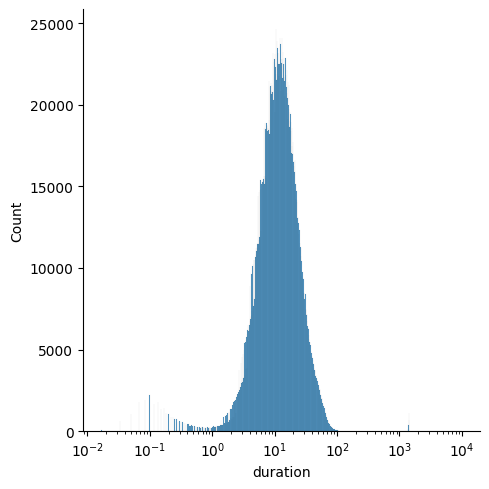

In [7]:
sns.displot(df['duration'], log_scale=True);

What fraction of the records left after you dropped the outliers?

In [8]:
initial_count = len(df)
df = df[(df['duration'] >= 1) & (df['duration'] <= 60)]
percent_remaining = (len(df) / initial_count) * 100

In [9]:
print(f"Percentage of data remaining: {percent_remaining:.0f}%")

Percentage of data remaining: 98%


# Q4. One-hot encoding

Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

- Turn the dataframe into a list of dictionaries (remember to re-cast the ids to strings - otherwise it will label encode them)
- Fit a dictionary vectorizer
- Get a feature matrix from it


In [18]:
categorical = ['PULocationID', 'DOLocationID']
df[categorical] = df[categorical].astype(str)
list_of_dicts = df[categorical].to_dict(orient='records')

What's the dimensionality of this matrix (number of columns)?

In [12]:
dv = DictVectorizer()
X_train = dv.fit_transform(list_of_dicts)
print(f"Dimensionality: {X_train.shape[1]}")

Dimensionality: 515


# Q5. Training a model

Now let's use the feature matrix from the previous step to train a model.

- Train a plain linear regression model with default parameters, where duration is the response variable
- Calculate the RMSE of the model on the training data

In [14]:
y_train = df['duration'].values

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

What's the RMSE on train?

In [15]:
y_pred = lr.predict(X_train)
print(f"Training RMSE: {root_mean_squared_error(y_train, y_pred):.2f} minutes")

Training RMSE: 7.65 minutes


# Q6. Evaluating the model

Now let's apply this model to the validation dataset (February 2023).

In [29]:
df_val = pd.read_parquet("./data/yellow_tripdata_2023-02.parquet")
df_val['duration'] = df_val['tpep_dropoff_datetime'] - df_val['tpep_pickup_datetime']
df_val['duration'] = df_val['duration'].dt.total_seconds() / 60

df_val = df_val[(df_val['duration'] >= 1) & (df_val['duration'] <= 60)]

categorical = ['PULocationID', 'DOLocationID']
df_val[categorical] = df_val[categorical].astype(str)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

What's the RMSE on validation?

In [30]:
y_val = df_val['duration'].values
y_pred = lr.predict(X_val)
print(f"Validation RMSE: {root_mean_squared_error(y_val, y_pred):.2f} minutes")

Validation RMSE: 7.81 minutes
